# Clusterização Hierárquica

## 1. Introdução

Neste notebook, exploraremos os algoritmos de clusterização hierárquica, uma família de métodos que constrói uma hierarquia de clusters organizando os dados em uma estrutura semelhante a uma árvore. Diferentemente do K-Means, que requer que especifiquemos o número de clusters antecipadamente, a clusterização hierárquica nos permite descobrir a estrutura natural dos dados em diferentes níveis de granularidade.

A clusterização hierárquica pode ser dividida em duas abordagens principais:
- **Aglomerativa (Bottom-up)**: Inicia com cada ponto como um cluster individual e, iterativamente, combina os clusters mais próximos até formar um único cluster.
- **Divisiva (Top-down)**: Inicia com todos os pontos em um único cluster e, recursivamente, divide os clusters até que cada ponto forme seu próprio cluster.

### Conteúdos abordados:

* **Fundamentação Matemática**: Métricas de distância entre clusters e critérios de ligação.
* **Implementação em Python**: Construção do algoritmo aglomerativo passo a passo usando NumPy.
* **Dendrogramas**: Visualização da hierarquia de clusters.
* **Critérios de Ligação**: Single, Complete, Average e Ward.
* **Determinação do Número de Clusters**: Métodos para "cortar" o dendrograma.
* **Aplicações Práticas**: Análise de dados reais e comparação com K-Means.

In [1]:
# Célula de importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import seaborn as sns

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Fundamentação Matemática da Clusterização Hierárquica

A clusterização hierárquica aglomerativa funciona com base em uma **matriz de distâncias** entre todos os pares de pontos (ou clusters). O algoritmo segue estes passos fundamentais:

1. **Inicialização**: Cada observação $\mathbf{x}_i$ forma um cluster individual $C_i = \{\mathbf{x}_i\}$.

2. **Cálculo da Matriz de Distâncias**: Para $N$ pontos, calculamos uma matriz simétrica $D \in \mathbb{R}^{N \times N}$ onde $D_{ij}$ representa a distância entre os pontos $\mathbf{x}_i$ e $\mathbf{x}_j$:
   $$ D_{ij} = d(\mathbf{x}_i, \mathbf{x}_j) $$

3. **Iteração**: Em cada passo, encontramos o par de clusters $(C_i, C_j)$ com menor distância e os combinamos em um novo cluster $C_{ij} = C_i \cup C_j$.

4. **Atualização**: Recalculamos as distâncias do novo cluster para todos os outros clusters existentes.

5. **Terminação**: O processo continua até que reste apenas um cluster contendo todas as observações.

### Critérios de Ligação (Linkage)

O ponto crucial da clusterização hierárquica é como definimos a distância entre dois clusters. Existem vários critérios de ligação:

1. **Single Linkage (Ligação Simples)**:
   $$ d(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais próximos entre os clusters.

2. **Complete Linkage (Ligação Completa)**:
   $$ d(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais distantes entre os clusters.

3. **Average Linkage (Ligação Média)**:
   $$ d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é a média de todas as distâncias entre pares de pontos dos clusters.

4. **Ward Linkage (Critério de Ward)**:
   $$d(C_i, C_j) = \frac{|C_i||C_j|}{|C_i|+|C_j|} \|\mathbf{m}_i - \mathbf{m}_j\|^2$$
   Onde $\mathbf{m}_i$ e $\mathbf{m}_j$ são os centróides dos clusters $C_i$ e $C_j$, respectivamente, e $|C_k|$ é o número de pontos no cluster $C_k$.
   Minimiza a variância intra-cluster ao combinar clusters. É baseado na soma dos quadrados das distâncias aos centróides.

## 3. Preparação dos Dados

Vamos começar com um exemplo simples usando dados sintéticos para entender visualmente como funciona a clusterização hierárquica. Depois, aplicaremos o algoritmo ao dataset Iris.

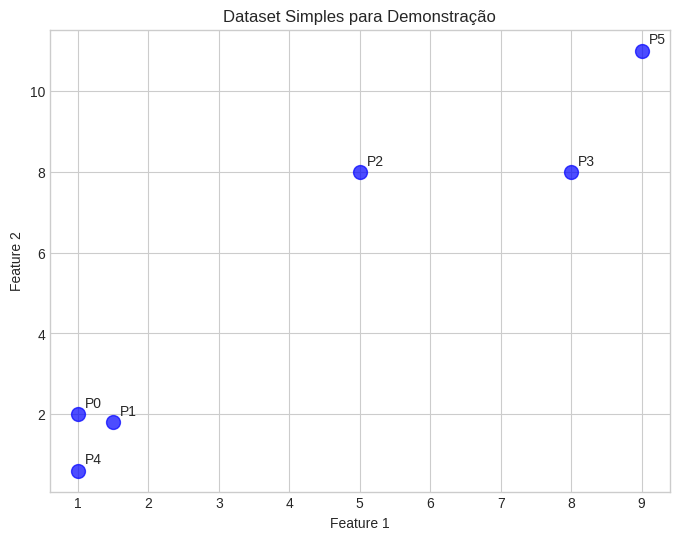

Coordenadas dos pontos:
P0: [1. 2.]
P1: [1.5 1.8]
P2: [5. 8.]
P3: [8. 8.]
P4: [1.  0.6]
P5: [ 9. 11.]


In [2]:
# Gerando dados sintéticos simples para demonstração
np.random.seed(42)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

# Visualizar os dados
plt.figure(figsize=(8, 6))
plt.scatter(X_simple[:, 0], X_simple[:, 1], c='blue', s=100, alpha=0.7)
for i, (x, y) in enumerate(X_simple):
    plt.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
plt.title('Dataset Simples para Demonstração')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

print(f"Coordenadas dos pontos:")
for i, point in enumerate(X_simple):
    print(f"P{i}: {point}")

## 4. Implementação do Algoritmo Hierárquico Aglomerativo

Vamos construir uma implementação simplificada do algoritmo hierárquico aglomerativo para entender seus passos fundamentais.

In [ ]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.
        
        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []
        
    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
                
        return dist_matrix
    
    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist
            
        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist
            
        # elif self.linkage == 'average':
        # Distância média entre todos os pares de pontos dos clusters
        # ...
    
    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)
        
        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]
        
        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)
        
        self.merge_history = []
        self.distances = []
        
        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")
        
        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1
            
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j
            
            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]
            
            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)
            
            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")
            
            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)
            
            print(f"Clusters restantes: {clusters}\n")

## 5. Executando o Algoritmo no Dataset Simples

Vamos aplicar nossa implementação nos dados simples para observar passo a passo como os clusters são formados.

In [ ]:
# Executar a clusterização hierárquica com ligação simples
hc_single = HierarchicalClustering(linkage='single')
hc_single.fit(X_simple)

## 6. Dendrogramas: Visualizando a Hierarquia

Um **dendrograma** é a representação gráfica da hierarquia de clusters. É uma estrutura em forma de árvore que mostra a ordem e as distâncias nas quais os clusters foram combinados.

### Interpretação do Dendrograma:
- **Eixo horizontal**: Representa as observações ou clusters.
- **Eixo vertical**: Representa a distância na qual os clusters foram unidos.
- **Altura dos ramos**: Indica a dissimilaridade entre os clusters combinados.

Vamos usar a implementação otimizada do SciPy para criar dendrogramas profissionais:

### Usando as Funções `linkage` e `fcluster` do SciPy

O SciPy fornece funções otimizadas para clusterização hierárquica que são muito mais eficientes que nossa implementação educacional. As duas funções principais são:

#### 1. Função `linkage(X, method)`

A função `linkage` calcula a matriz de ligação que representa a hierarquia de clusters:

```python
from scipy.cluster.hierarchy import linkage

# Sintaxe básica
linkage_matrix = linkage(X, method='ward')
```

**Parâmetros principais:**
- `X`: matriz de dados (n_samples × n_features)
- `method`: critério de ligação ('single', 'complete', 'average', 'ward')
- `metric`: métrica de distância (padrão: 'euclidean')

**Retorno:**
- Matriz (n-1) × 4 onde cada linha representa uma fusão:
  - Colunas 0 e 1: índices dos clusters sendo combinados
  - Coluna 2: distância da fusão
  - Coluna 3: número de observações no novo cluster

#### 2. Função `fcluster(Z, t, criterion)`

A função `fcluster` extrai clusters da matriz de ligação com base em um critério de corte:

```python
from scipy.cluster.hierarchy import fcluster

# Obter clusters com base na distância
clusters = fcluster(linkage_matrix, t=3.0, criterion='distance')

# Obter um número específico de clusters
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
```

**Parâmetros principais:**
- `Z`: matriz de ligação (resultado de `linkage`)
- `t`: valor do critério de corte
- `criterion`: tipo de critério ('distance', 'maxclust', 'inconsistent')

**Critérios de corte:**
- `'distance'`: corta em uma altura específica do dendrograma
- `'maxclust'`: força um número específico de clusters
- `'inconsistent'`: baseado no coeficiente de inconsistência

In [ ]:
# Usando scipy para criar dendrogramas profissionais
# Diferentes critérios de ligação

linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_simple, method=method)
    
    # Criar o dendrograma
    dendrogram(linkage_matrix, ax=axes[i], labels=[f'P{j}' for j in range(len(X_simple))])
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Pontos de Dados')
    axes[i].set_ylabel('Distância')

plt.tight_layout()
plt.show()

### Comparação dos Critérios de Ligação

Cada critério de ligação produz diferentes estruturas de cluster:

- **Single Linkage**: Tende a criar clusters elongados e pode sofrer do "efeito corrente" (chaining effect).
- **Complete Linkage**: Produz clusters mais compactos e esféricos.
- **Average Linkage**: Um meio-termo entre single e complete.
- **Ward Linkage**: Minimiza a variância intra-cluster, similar ao objetivo do K-Means.

## 7. Determinando o Número de Clusters

Uma das grandes vantagens da clusterização hierárquica é que podemos "cortar" o dendrograma em diferentes alturas para obter diferentes números de clusters. Isso é feito traçando uma linha horizontal através do dendrograma.

In [ ]:
# Usar Ward linkage para o exemplo
linkage_matrix = linkage(X_simple, method='ward')

# Definir diferentes alturas de corte
cut_heights = [2.0, 4.0, 6.0]
colors = ['red', 'green', 'blue']

# Visualizar o dendrograma com diferentes cortes
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=[f'P{j}' for j in range(len(X_simple))])

for height, color in zip(cut_heights, colors):
    plt.axhline(y=height, color=color, linestyle='--', label=f'Corte em {height}')

plt.title('Dendrograma com Linhas de Corte')
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância')
plt.legend()
plt.show()

In [ ]:
# Predição de clusters baseada em diferentes linhas de corte
from scipy.cluster.hierarchy import fcluster

print("Predição de clusters para diferentes alturas de corte:")
print("=" * 55)

for i, height in enumerate(cut_heights):
    # Obter clusters para a altura de corte específica
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    n_clusters = len(np.unique(clusters))
    
    print()
    print(f"Altura de corte: {height}")
    print(f"Número de clusters: {n_clusters}")
    
    # Mostrar quais pontos pertencem a cada cluster
    for cluster_id in np.unique(clusters):
        points = [f"P{j}" for j in range(len(X_simple)) if clusters[j] == cluster_id]
        print(f"  Cluster {cluster_id}: {points}")

In [ ]:
# Visualização dos clusters resultantes
fig, axes = plt.subplots(1, len(cut_heights), figsize=(15, 4))

for i, height in enumerate(cut_heights):
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    scatter = axes[i].scatter(X_simple[:, 0], X_simple[:, 1], c=clusters, s=100, alpha=0.7, cmap='viridis')
    
    # Adicionar rótulos dos pontos
    for j, (x, y) in enumerate(X_simple):
        axes[i].annotate(f'P{j}', (x, y), xytext=(5, 5), textcoords='offset points')
    
    axes[i].set_title(f'Clusters (corte = {height})\n{len(np.unique(clusters))} clusters')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## 8. Aplicação ao Dataset Iris

Agora vamos aplicar a clusterização hierárquica ao dataset Iris e comparar os resultados com o K-Means.

In [ ]:
# Carregar o dataset Iris
iris = load_iris()
X_iris = iris.data[:, 2:]  # Usar comprimento e largura da pétala
y_true = iris.target

# Aplicar diferentes métodos de ligação
methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, method in enumerate(methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_iris, method=method)
    
    # Dendrograma
    dendrogram(linkage_matrix, ax=axes[0, i], no_labels=True)
    axes[0, i].set_title(f'Dendrograma - {method.capitalize()}')
    
    # Obter 3 clusters
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    
    # Plotar os clusters
    scatter = axes[1, i].scatter(X_iris[:, 0], X_iris[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[1, i].set_title(f'Clusters - {method.capitalize()}')
    axes[1, i].set_xlabel('Comprimento da Pétala')
    axes[1, i].set_ylabel('Largura da Pétala')
    
plt.tight_layout()
plt.show()

### Avaliação dos Resultados

Vamos calcular a taxa de acertos para cada método de ligação:

In [ ]:
from scipy.stats import mode

def calculate_purity(y_true, y_pred):
    """
    Calcula a pureza dos clusters comparando com os rótulos verdadeiros.
    """
    correct_predictions = 0
    n_samples = len(y_true)
    
    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)
    
    return correct_predictions / n_samples

print("Comparação dos métodos de ligação no dataset Iris:")
print("="*50)

for method in methods:
    linkage_matrix = linkage(X_iris, method=method)
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    purity = calculate_purity(y_true, clusters)
    print(f"{method.capitalize():12} Linkage: {purity:.1%} de acertos")

### Exercício 1: Implementação do Average Linkage

Complete a implementação da nossa classe `HierarchicalClustering` adicionando o método **Average Linkage**. Em seguida, teste todos os três métodos de ligação (single, complete, average) no dataset simples (`X_simple`) e compare os resultados.

In [3]:
# Exercício 1: Implementação do Average Linkage

class HierarchicalClusteringComplete:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.
        
        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []
        
    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
                
        return dist_matrix
    
    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist
            
        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist
            
        elif self.linkage == 'average':
            # Distância média entre todos os pares de pontos dos clusters
            total_distance = 0
            count = 0
            for i in cluster1:
                for j in cluster2:
                    total_distance += dist_matrix[i, j]
                    count += 1
            return total_distance / count if count > 0 else 0
    
    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)
        
        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]
        
        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)
        
        self.merge_history = []
        self.distances = []
        
        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")
        
        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1
            
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j
            
            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]
            
            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)
            
            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")
            
            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)
            
            print(f"Clusters restantes: {clusters}\n")

# Testando todos os três métodos de ligação no dataset simples
linkage_methods = ['single', 'complete', 'average']

print("=== COMPARAÇÃO DOS MÉTODOS DE LIGAÇÃO NO DATASET SIMPLES ===")
print("Dataset:")
for i, point in enumerate(X_simple):
    print(f"P{i}: {point}")
print("\n")

for method in linkage_methods:
    print(f"{'='*60}")
    print(f"MÉTODO: {method.upper()} LINKAGE")
    print(f"{'='*60}")
    
    hc = HierarchicalClusteringComplete(linkage=method)
    hc.fit(X_simple)
    
    print("\n")

=== COMPARAÇÃO DOS MÉTODOS DE LIGAÇÃO NO DATASET SIMPLES ===
Dataset:
P0: [1. 2.]
P1: [1.5 1.8]
P2: [5. 8.]
P3: [8. 8.]
P4: [1.  0.6]
P5: [ 9. 11.]


MÉTODO: SINGLE LINKAGE
Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.300
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Combinar clusters [5] e [2, 3]
Distância: 3.162
Clusters restantes: [[4, 0, 1], [5, 2, 3]]

Passo 5: Combinar clusters [4, 0, 1] e [5, 2, 3]
Distância: 7.120
Clusters restantes: [[4, 0, 1, 5, 2, 3]]



MÉTODO: COMPLETE LINKAGE
Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar 

### Exercício 2: Análise do Dataset Wine - Seleção de Features e Comparação de Métodos

Aplique a clusterização hierárquica do SciPy ao dataset Wine. Primeiro, você deve selecionar um bom par de features para visualização bidimensional, depois comparar diferentes métodos de ligação.

**Tarefas:**
1. Carregue o dataset Wine e explore suas features
2. Selecione as duas melhores features para visualização (analise correlações, variâncias, etc.)
3. Aplique os 4 métodos de ligação ('single', 'complete', 'average', 'ward') usando `scipy.cluster.hierarchy.linkage`
4. Crie dendrogramas para cada método
5. Determine visualmente qual método produz a melhor separação

Dataset Wine:
Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']

=== ANÁLISE DAS FEATURES ===

=== ANÁLISE DE VARIÂNCIA ===
Top 10 features com maior variância:
proline                         99166.717355
magnesium                         203.989335
alcalinity_of_ash                  11.152686
color_intensity                     5.374449
malic_acid                          1.248015
flavanoids                          0.997719
alcohol                             0.659062
od280/od315_of_diluted_wines        0.504086
total_phenols                       0.391690
proanthocyanins                     0.327595
dtype: float64

=== SELEÇÃO DAS MELHORES FEATURES ===
Ranking das melhores features:
                                           feature  fisher_score  \
alcohol 

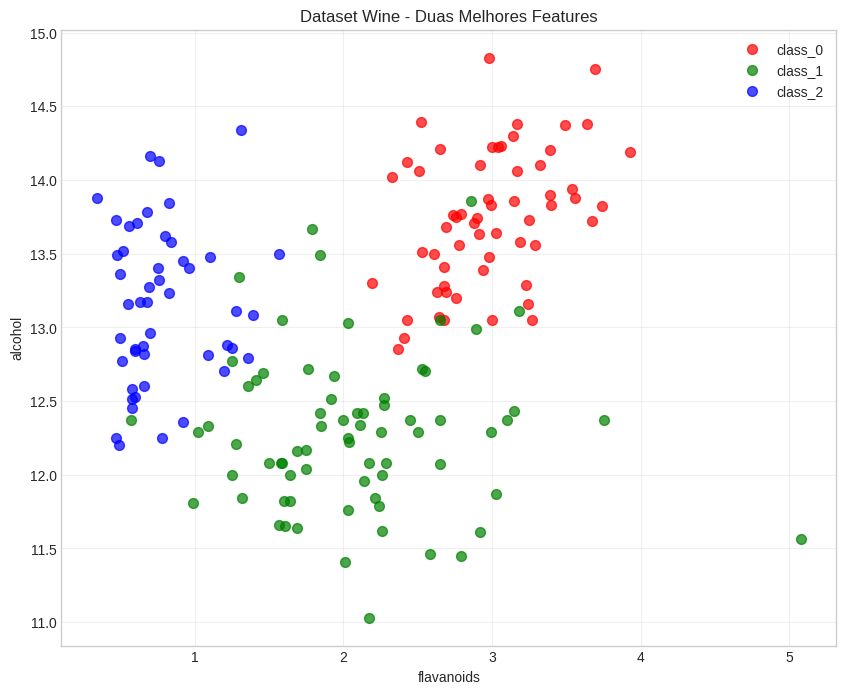


=== APLICAÇÃO DOS 4 MÉTODOS DE LIGAÇÃO ===


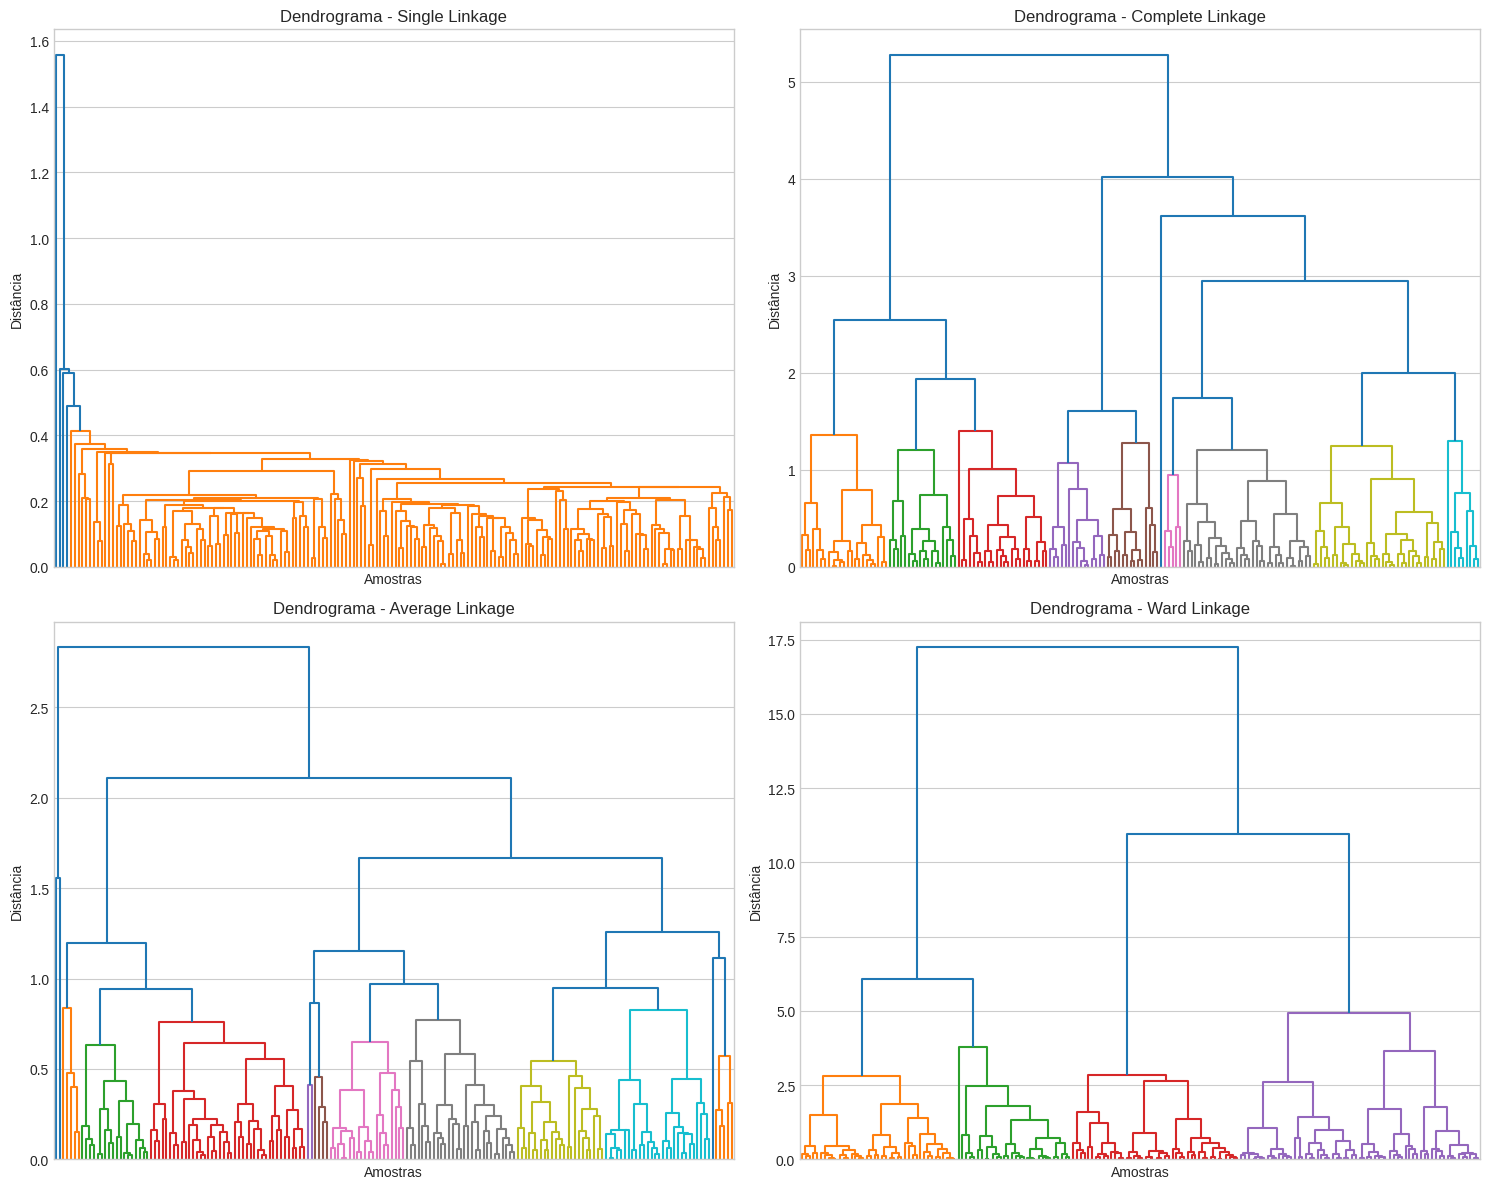


=== ANÁLISE DOS CLUSTERS PARA CADA MÉTODO ===


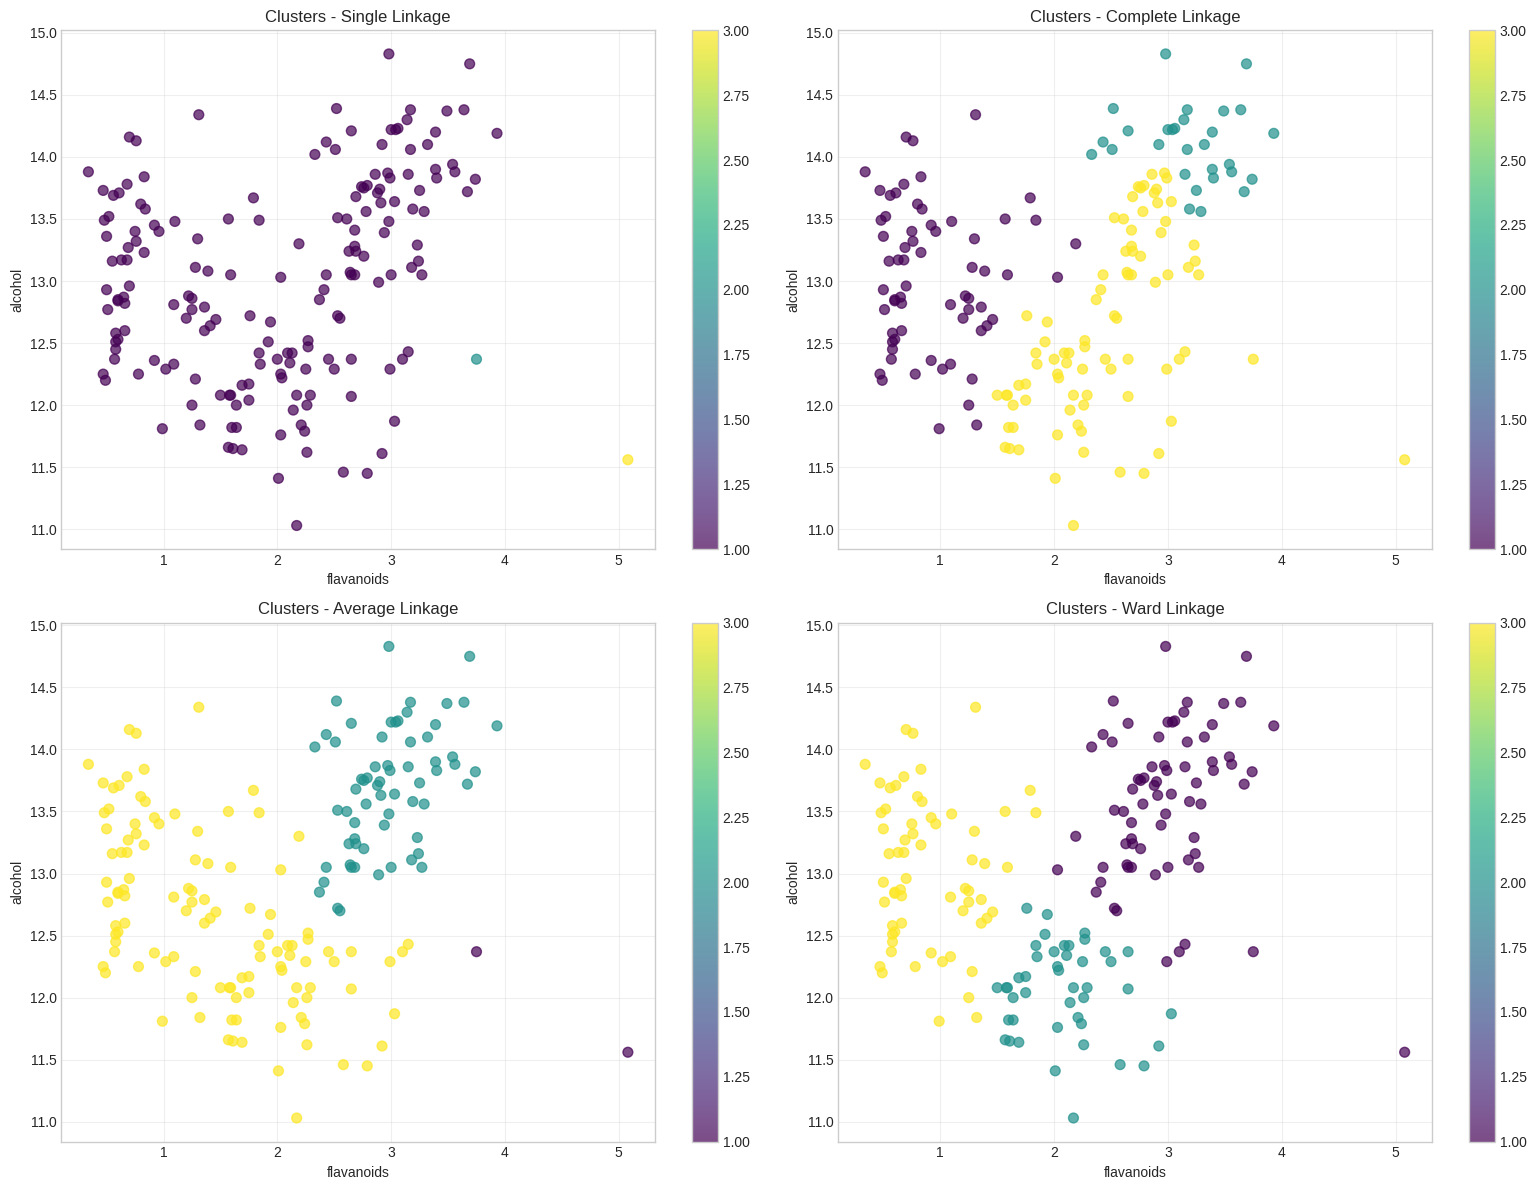


=== AVALIAÇÃO DA QUALIDADE DOS CLUSTERS ===
Comparação dos métodos de ligação:
Método       Pureza   ARI      Silhouette  
single       0.399    -0.004   0.179       
complete     0.742    0.421    0.343       
average      0.691    0.492    0.450       
ward         0.848    0.604    0.472       

Melhor método: WARD LINKAGE
Score combinado: 0.728


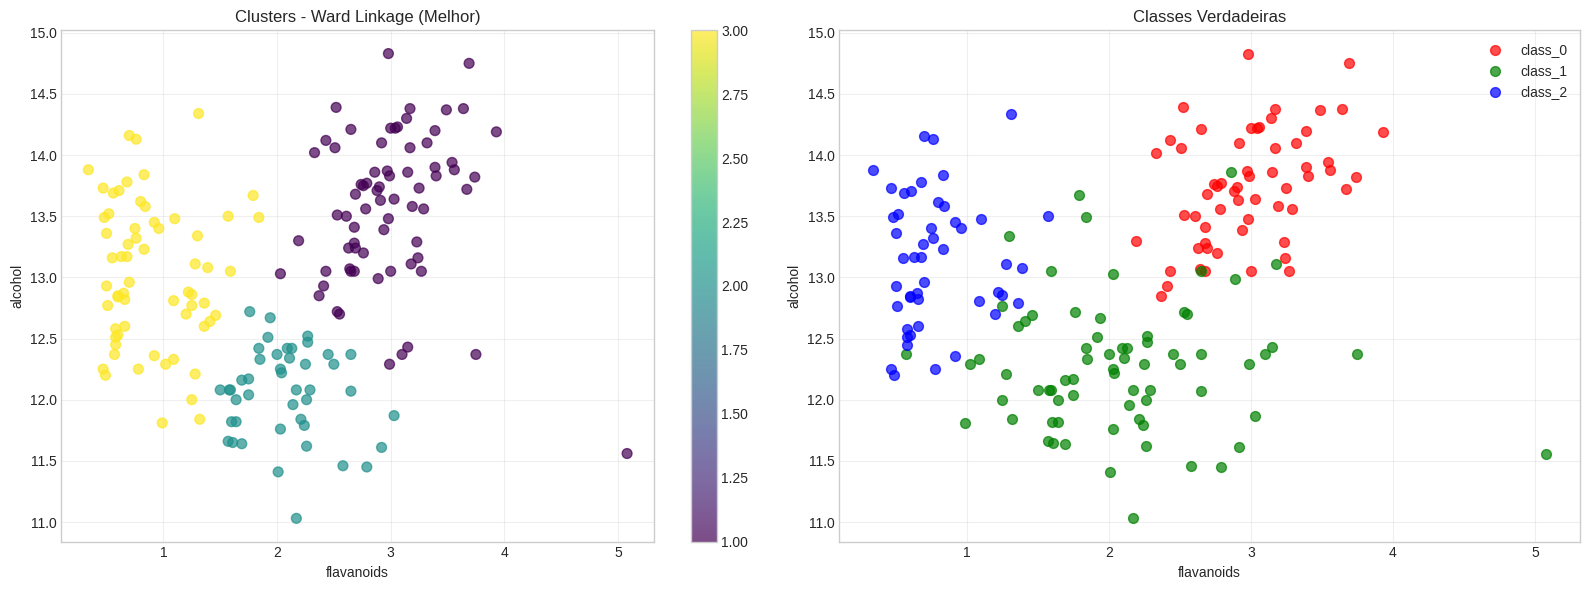

In [6]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Shape: {X_wine.shape}")
print(f"Features: {wine.feature_names}")
print(f"Classes: {wine.target_names}")

# 2. Análise das features para seleção
print("\n=== ANÁLISE DAS FEATURES ===")

# Criar DataFrame para facilitar a análise
df_wine = pd.DataFrame(X_wine, columns=wine.feature_names)
df_wine['target'] = y_wine

# Analisar variância das features
print("\n=== ANÁLISE DE VARIÂNCIA ===")
variances = df_wine.drop('target', axis=1).var().sort_values(ascending=False)
print("Top 10 features com maior variância:")
print(variances.head(10))

# 3. Seleção das duas melhores features
# Vamos usar uma combinação de critérios: variância alta e boa separabilidade entre classes

print("\n=== SELEÇÃO DAS MELHORES FEATURES ===")

def calculate_fisher_score(X, y):
    """Calcula o Fisher Score para cada feature"""
    fisher_scores = []
    
    for i in range(X.shape[1]):
        feature_data = X[:, i]
        
        # Calcular médias por classe
        class_means = []
        class_vars = []
        
        for class_idx in np.unique(y):
            class_data = feature_data[y == class_idx]
            class_means.append(np.mean(class_data))
            class_vars.append(np.var(class_data))
        
        # Variância entre classes
        overall_mean = np.mean(feature_data)
        between_class_var = np.sum([(mean - overall_mean)**2 for mean in class_means])
        
        # Variância intra-classe média
        within_class_var = np.mean(class_vars)
        
        # Fisher Score
        if within_class_var > 0:
            fisher_score = between_class_var / within_class_var
        else:
            fisher_score = 0
            
        fisher_scores.append(fisher_score)
    
    return np.array(fisher_scores)

fisher_scores = calculate_fisher_score(X_wine, y_wine)
feature_scores = pd.DataFrame({
    'feature': wine.feature_names,
    'fisher_score': fisher_scores,
    'variance': variances
})

# Normalizar os scores e combinar
feature_scores['fisher_norm'] = (feature_scores['fisher_score'] - feature_scores['fisher_score'].min()) / (feature_scores['fisher_score'].max() - feature_scores['fisher_score'].min())
feature_scores['variance_norm'] = (feature_scores['variance'] - feature_scores['variance'].min()) / (feature_scores['variance'].max() - feature_scores['variance'].min())

# Score combinado (Fisher Score tem mais peso)
feature_scores['combined_score'] = 0.7 * feature_scores['fisher_norm'] + 0.3 * feature_scores['variance_norm']

# Ordenar por score combinado
feature_scores = feature_scores.sort_values('combined_score', ascending=False)

print("Ranking das melhores features:")
print(feature_scores[['feature', 'fisher_score', 'variance', 'combined_score']].head(10))

# Selecionar as duas melhores features
best_features = feature_scores.head(2)['feature'].values
best_indices = [wine.feature_names.index(feature) for feature in best_features]

print(f"\nDuas melhores features selecionadas:")
print(f"1. {best_features[0]}")
print(f"2. {best_features[1]}")

# Criar dataset com as duas melhores features
X_wine_2d = X_wine[:, best_indices]

print(f"\nDataset reduzido: {X_wine_2d.shape}")

# Visualizar as duas melhores features
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i, class_name in enumerate(wine.target_names):
    mask = y_wine == i
    plt.scatter(X_wine_2d[mask, 0], X_wine_2d[mask, 1], 
               c=colors[i], label=class_name, alpha=0.7, s=50)

plt.xlabel(best_features[0])
plt.ylabel(best_features[1])
plt.title('Dataset Wine - Duas Melhores Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Aplicação dos métodos de ligação e criação dos dendrogramas
print("\n=== APLICAÇÃO DOS 4 MÉTODOS DE LIGAÇÃO ===")

from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode

linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

# Criar subplot para dendrogramas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calcular matriz de ligação
    linkage_matrix = linkage(X_wine_2d, method=method)
    linkage_matrices[method] = linkage_matrix
    
    # Criar dendrograma
    dendrogram(linkage_matrix, ax=axes[i], no_labels=True, 
               color_threshold=0.3*np.max(linkage_matrix[:, 2]))
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Amostras')
    axes[i].set_ylabel('Distância')

plt.tight_layout()
plt.show()

# 5. Análise visual e determinação do melhor método
print("\n=== ANÁLISE DOS CLUSTERS PARA CADA MÉTODO ===")

# Visualizar clusters para cada método (usando 3 clusters)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

cluster_results = {}

for i, method in enumerate(linkage_methods):
    # Obter 3 clusters
    clusters = fcluster(linkage_matrices[method], 3, criterion='maxclust')
    cluster_results[method] = clusters
    
    # Plotar clusters
    scatter = axes[i].scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=clusters, 
                            s=50, alpha=0.7, cmap='viridis')
    axes[i].set_title(f'Clusters - {method.capitalize()} Linkage')
    axes[i].set_xlabel(best_features[0])
    axes[i].set_ylabel(best_features[1])
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar colorbar
    plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

# Avaliar qualidade dos clusters
print("\n=== AVALIAÇÃO DA QUALIDADE DOS CLUSTERS ===")

def calculate_purity(y_true, y_pred):
    """
    Calcula a pureza dos clusters comparando com os rótulos verdadeiros.
    """
    correct_predictions = 0
    n_samples = len(y_true)
    
    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)
    
    return correct_predictions / n_samples

from sklearn.metrics import adjusted_rand_score, silhouette_score

print("Comparação dos métodos de ligação:")
print("="*50)
print(f"{'Método':<12} {'Pureza':<8} {'ARI':<8} {'Silhouette':<12}")
print("="*50)

best_method = None
best_score = -1

for method in linkage_methods:
    clusters = cluster_results[method]
    purity = calculate_purity(y_wine, clusters)
    ari = adjusted_rand_score(y_wine, clusters)
    sil_score = silhouette_score(X_wine_2d, clusters)
    
    # Score combinado (média ponderada)
    combined_score = 0.4 * purity + 0.4 * ari + 0.2 * (sil_score + 1) / 2
    
    print(f"{method:<12} {purity:<8.3f} {ari:<8.3f} {sil_score:<12.3f}")
    
    if combined_score > best_score:
        best_score = combined_score
        best_method = method

print("="*50)
print(f"\nMelhor método: {best_method.upper()} LINKAGE")
print(f"Score combinado: {best_score:.3f}")

# Visualização comparativa: clusters vs classes verdadeiras
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Clusters do melhor método
best_clusters = cluster_results[best_method]
scatter1 = axes[0].scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=best_clusters, 
                          s=50, alpha=0.7, cmap='viridis')
axes[0].set_title(f'Clusters - {best_method.capitalize()} Linkage (Melhor)')
axes[0].set_xlabel(best_features[0])
axes[0].set_ylabel(best_features[1])
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# Classes verdadeiras
colors_true = ['red', 'green', 'blue']
for i, class_name in enumerate(wine.target_names):
    mask = y_wine == i
    axes[1].scatter(X_wine_2d[mask, 0], X_wine_2d[mask, 1], 
                   c=colors_true[i], label=class_name, alpha=0.7, s=50)

axes[1].set_title('Classes Verdadeiras')
axes[1].set_xlabel(best_features[0])
axes[1].set_ylabel(best_features[1])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Exercício 3: Determinação do Número Ótimo de Clusters

Com base no melhor método de ligação identificado no Exercício 2, determine o número ótimo de clusters para o dataset Wine usando análise visual do dendrograma e validação com os rótulos verdadeiros.

**Tarefas:**
1. Use o melhor método identificado no exercício anterior
2. Crie um dendrograma detalhado com linha de corte ajustável
3. Teste diferentes números de clusters (2, 3, 4, 5) usando `fcluster`
4. Para cada número de clusters, visualize os clusters no scatter plot
5. Determine o número ótimo de clusters justificando sua escolha

Usando o método WARD identificado como melhor no Exercício 2

=== ANÁLISE DO DENDROGRAMA PARA DIFERENTES CORTES ===


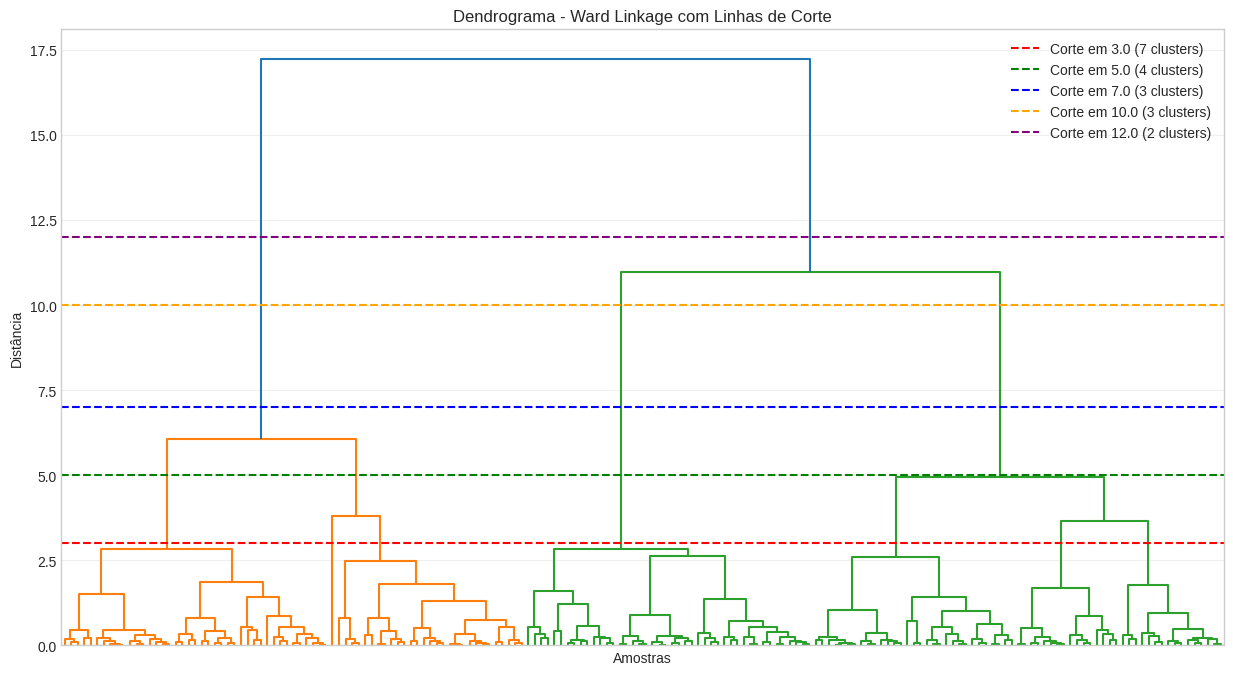

Análise do número ótimo de clusters:


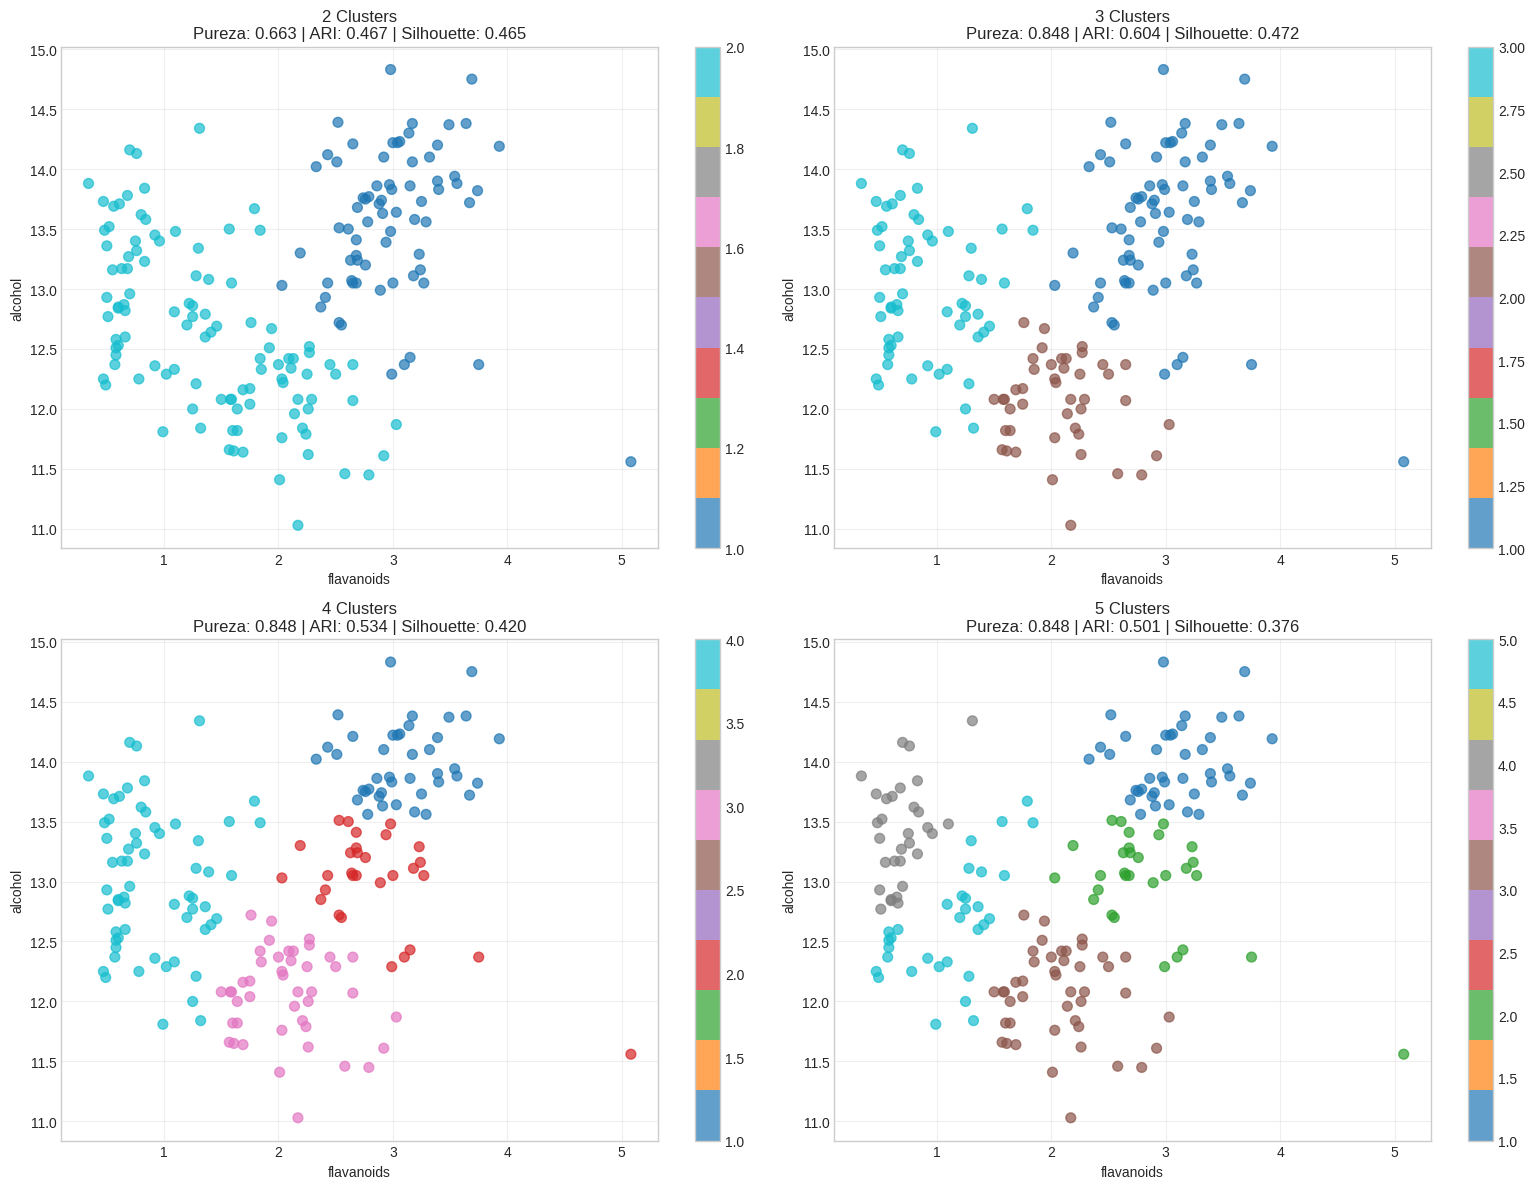


Resumo das Métricas por Número de Clusters:
N_Clusters   Pureza   ARI      Silhouette   Score Comb  
2            0.663    0.467    0.465        0.598       
3            0.848    0.604    0.472        0.728       
4            0.848    0.534    0.420        0.695       
5            0.848    0.501    0.376        0.677       

Número ótimo de clusters: 3
Score combinado: 0.728

=== ANÁLISE DETALHADA DOS 3 CLUSTERS ÓTIMOS ===
Tabela de Confusão - Classes Verdadeiras vs Clusters:
                    Cluster 1  Cluster 2  Cluster 3
Classe 0 (class_0)         59          0          0
Classe 1 (class_1)         12         44         15
Classe 2 (class_2)          0          0         48

Análise por Cluster:
Cluster 1: 71 amostras, classe dominante: class_0 (59/71 = 83.1%)
Cluster 2: 44 amostras, classe dominante: class_1 (44/44 = 100.0%)
Cluster 3: 63 amostras, classe dominante: class_2 (48/63 = 76.2%)

=== VISUALIZAÇÃO COMPARATIVA ===


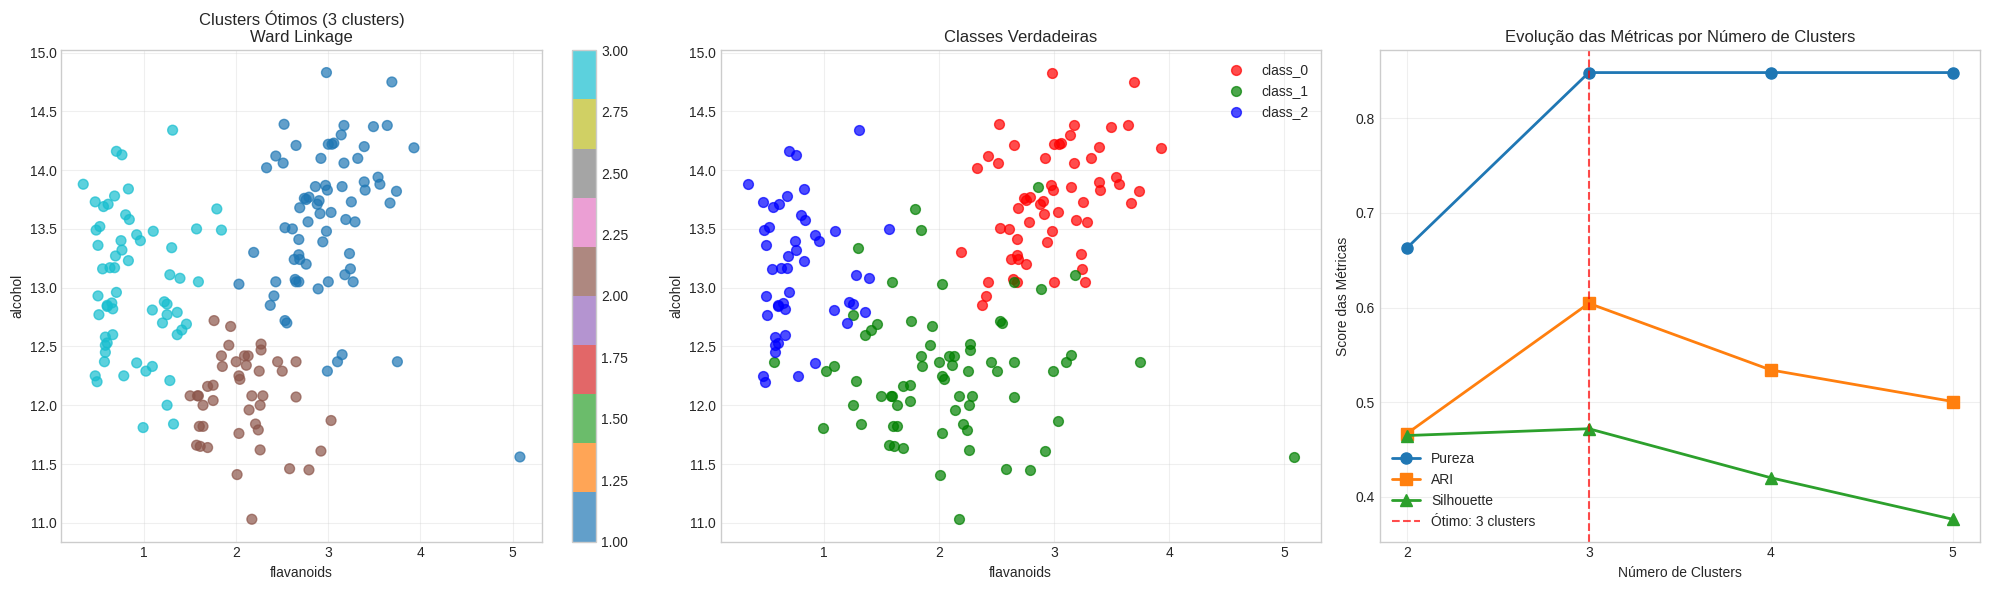


=== CONCLUSÕES ===
1. Melhor método de ligação: WARD
2. Número ótimo de clusters: 3
3. Melhores features selecionadas: flavanoids e alcohol
4. Pureza alcançada: 84.8%
5. ARI (Adjusted Rand Index): 0.604
6. Silhouette Score: 0.472

O método Ward com 3 clusters apresentou o melhor desempenho,
conseguindo separar bem as classes do dataset Wine usando apenas as duas
features mais discriminativas: flavanoids e alcohol.


In [7]:
# Exercício 3: Determinação do Número Ótimo de Clusters

# 1. Use o melhor método do exercício anterior
best_method = 'ward'
print(f"Usando o método {best_method.upper()} identificado como melhor no Exercício 2")

# Usar a matriz de ligação já calculada
linkage_matrix = linkage(X_wine_2d, method=best_method)

# 2. Crie dendrograma com diferentes linhas de corte
print("\n=== ANÁLISE DO DENDROGRAMA PARA DIFERENTES CORTES ===")

# Definir diferentes alturas de corte para análise
cut_heights = [3.0, 5.0, 7.0, 10.0, 12.0]
colors_cut = ['red', 'green', 'blue', 'orange', 'purple']

# Visualizar dendrograma com linhas de corte
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, no_labels=True, color_threshold=None)

for i, (height, color) in enumerate(zip(cut_heights, colors_cut)):
    plt.axhline(y=height, color=color, linestyle='--', 
                label=f'Corte em {height} ({len(np.unique(fcluster(linkage_matrix, height, criterion="distance")))} clusters)')

plt.title(f'Dendrograma - {best_method.capitalize()} Linkage com Linhas de Corte')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Teste diferentes números de clusters
n_clusters_to_test = [2, 3, 4, 5]

print("Análise do número ótimo de clusters:")
print("=" * 40)

# Calcular métricas para cada número de clusters
cluster_metrics = []

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, n_clusters in enumerate(n_clusters_to_test):
    # Obter clusters
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Calcular métricas
    purity = calculate_purity(y_wine, clusters)
    ari = adjusted_rand_score(y_wine, clusters)
    sil_score = silhouette_score(X_wine_2d, clusters)
    
    cluster_metrics.append({
        'n_clusters': n_clusters,
        'purity': purity,
        'ari': ari,
        'silhouette': sil_score
    })
    
    # Visualizar clusters
    scatter = axes[i].scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=clusters, 
                            s=50, alpha=0.7, cmap='tab10')
    axes[i].set_title(f'{n_clusters} Clusters\nPureza: {purity:.3f} | ARI: {ari:.3f} | Silhouette: {sil_score:.3f}')
    axes[i].set_xlabel(best_features[0])
    axes[i].set_ylabel(best_features[1])
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar colorbar
    plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

# Análise detalhada das métricas
print("\nResumo das Métricas por Número de Clusters:")
print("=" * 60)
print(f"{'N_Clusters':<12} {'Pureza':<8} {'ARI':<8} {'Silhouette':<12} {'Score Comb':<12}")
print("=" * 60)

best_n_clusters = None
best_combined_score = -1

for metrics in cluster_metrics:
    n_clusters = metrics['n_clusters']
    purity = metrics['purity']
    ari = metrics['ari']
    sil_score = metrics['silhouette']
    
    # Score combinado (mesma fórmula do exercício anterior)
    combined_score = 0.4 * purity + 0.4 * ari + 0.2 * (sil_score + 1) / 2
    
    print(f"{n_clusters:<12} {purity:<8.3f} {ari:<8.3f} {sil_score:<12.3f} {combined_score:<12.3f}")
    
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_n_clusters = n_clusters

print("=" * 60)
print(f"\nNúmero ótimo de clusters: {best_n_clusters}")
print(f"Score combinado: {best_combined_score:.3f}")

# 4. Análise da coerência dos clusters com as classes verdadeiras
print(f"\n=== ANÁLISE DETALHADA DOS {best_n_clusters} CLUSTERS ÓTIMOS ===")

optimal_clusters = fcluster(linkage_matrix, best_n_clusters, criterion='maxclust')

# Criar tabela de confusão
confusion_table = pd.DataFrame(
    [[np.sum((y_wine == true_class) & (optimal_clusters == cluster_id)) 
      for cluster_id in np.unique(optimal_clusters)]
     for true_class in np.unique(y_wine)],
    index=[f'Classe {i} ({wine.target_names[i]})' for i in range(len(wine.target_names))],
    columns=[f'Cluster {i}' for i in np.unique(optimal_clusters)]
)

print("Tabela de Confusão - Classes Verdadeiras vs Clusters:")
print(confusion_table)

# Análise por cluster
print(f"\nAnálise por Cluster:")
for cluster_id in np.unique(optimal_clusters):
    mask = optimal_clusters == cluster_id
    cluster_classes = y_wine[mask]
    dominant_class = mode(cluster_classes, keepdims=True)[0][0]
    dominant_count = np.sum(cluster_classes == dominant_class)
    total_count = len(cluster_classes)
    purity_cluster = dominant_count / total_count
    
    print(f"Cluster {cluster_id}: {total_count} amostras, "
          f"classe dominante: {wine.target_names[dominant_class]} "
          f"({dominant_count}/{total_count} = {purity_cluster:.1%})")

# 5. Visualização final comparativa
print(f"\n=== VISUALIZAÇÃO COMPARATIVA ===")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Clusters ótimos
scatter1 = axes[0].scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=optimal_clusters, 
                          s=50, alpha=0.7, cmap='tab10')
axes[0].set_title(f'Clusters Ótimos ({best_n_clusters} clusters)\n{best_method.capitalize()} Linkage')
axes[0].set_xlabel(best_features[0])
axes[0].set_ylabel(best_features[1])
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# Classes verdadeiras
colors_true = ['red', 'green', 'blue']
for i, class_name in enumerate(wine.target_names):
    mask = y_wine == i
    axes[1].scatter(X_wine_2d[mask, 0], X_wine_2d[mask, 1], 
                   c=colors_true[i], label=class_name, alpha=0.7, s=50)

axes[1].set_title('Classes Verdadeiras')
axes[1].set_xlabel(best_features[0])
axes[1].set_ylabel(best_features[1])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Comparação das métricas
metrics_df = pd.DataFrame(cluster_metrics)
x_pos = range(len(n_clusters_to_test))

axes[2].plot(x_pos, metrics_df['purity'], 'o-', label='Pureza', linewidth=2, markersize=8)
axes[2].plot(x_pos, metrics_df['ari'], 's-', label='ARI', linewidth=2, markersize=8)
axes[2].plot(x_pos, metrics_df['silhouette'], '^-', label='Silhouette', linewidth=2, markersize=8)

axes[2].set_xlabel('Número de Clusters')
axes[2].set_ylabel('Score das Métricas')
axes[2].set_title('Evolução das Métricas por Número de Clusters')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(n_clusters_to_test)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Destacar o ponto ótimo
optimal_idx = n_clusters_to_test.index(best_n_clusters)
axes[2].axvline(x=optimal_idx, color='red', linestyle='--', alpha=0.7, 
                label=f'Ótimo: {best_n_clusters} clusters')
axes[2].legend()

plt.tight_layout()
plt.show()

# 6. Conclusões
print(f"\n=== CONCLUSÕES ===")
print(f"1. Melhor método de ligação: {best_method.upper()}")
print(f"2. Número ótimo de clusters: {best_n_clusters}")
print(f"3. Melhores features selecionadas: {best_features[0]} e {best_features[1]}")
print(f"4. Pureza alcançada: {cluster_metrics[optimal_idx]['purity']:.1%}")
print(f"5. ARI (Adjusted Rand Index): {cluster_metrics[optimal_idx]['ari']:.3f}")
print(f"6. Silhouette Score: {cluster_metrics[optimal_idx]['silhouette']:.3f}")

print(f"\nO método Ward com {best_n_clusters} clusters apresentou o melhor desempenho,")
print(f"conseguindo separar bem as classes do dataset Wine usando apenas as duas")
print(f"features mais discriminativas: {best_features[0]} e {best_features[1]}.")